In [76]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/omarlibs/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg
from cuts import getGeoCuts, get_bgs, flux_to_mag
from QA import getStats, flow

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgs_main/')
from desitarget.cuts import select_targets
from desitarget import io, cuts

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio
import matplotlib.pyplot as plt
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## BGS assess comparison DESITARGET with MYCODE for DR8

In [2]:
#run my bgs script on one sweep brick
mastercat = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-190p000-200p005.fits'
cat = getBGSbits(mycatpath=mastercat, filename='erase', mycat=True, getmycat=True)

---- BGSMASK key: ---- 
	 BS, 0, 1
	 MS, 1, 2
	 GC, 2, 4
	 LG, 3, 8
	 allmask, 4, 16
	 nobs, 5, 32
	 SG, 6, 64
	 SGSV, 7, 128
	 FMC, 8, 256
	 FMC2, 9, 512
	 CC, 10, 1024
	 QC_FM, 11, 2048
	 QC_FI, 12, 4096
	 QC_FF, 13, 8192
	 QC_IVAR, 14, 16384
	 bgs_any, 20, 1048576
	 bgs_bright, 21, 2097152
	 bgs_faint, 22, 4194304
	 bgs_sv_any, 30, 1073741824
	 bgs_sv_bright, 31, 2147483648
	 bgs_sv_faint, 32, 4294967296
	 bgs_sv_faint_ext, 33, 8589934592
	 bgs_sv_fibmag, 34, 17179869184
	 bgs_sv_lowq, 35, 34359738368
---- Sanity Check ---- 
	 BS, 3877208, 3877208
	 MS, 3833070, 3833070
	 GC, 3949441, 3949441
	 LG, 3944640, 3944640
	 allmask, 3938037, 3938037
	 nobs, 3948722, 3948722
	 SG, 3766688, 3766688
	 SGSV, 3767362, 3767362
	 FMC, 3934115, 3934115
	 FMC2, 3934645, 3934645
	 CC, 3776143, 3776143
	 QC_FM, 3916707, 3916707
	 QC_FI, 3947746, 3947746
	 QC_FF, 3927142, 3927142
	 QC_IVAR, 3948524, 3948524
	 bgs_any, 65126, 65126
	 bgs_bright, 38416, 38416
	 bgs_faint, 26710, 26710
	 bgs_sv_any, 3767

In [92]:
#run desitarget on the same sweep brick
#see: /global/homes/q/qmxp55/DESI/bgs_main/select_targets_bgs.py
cat1 = fitsio.read('/global/cscratch1/sd/qmxp55/desitarget_output/test_lslga_1.fits/targets/main/resolve/targets-drX-hp-X.fits')

In [93]:
bgsf1 = (cat1['BGS_TARGET'] & 2**(0)) != 0
bgsb1 = (cat1['BGS_TARGET'] & 2**(1)) != 0

bgsb = ((cat['BGSBITS'] & 2**(21)) != 0)
bgsf = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs = ((cat['BGSBITS'] & 2**(20)) != 0)

In [94]:
print('Targ. Dens. of BGS faint: %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum(bgsf1)/47, np.sum(bgsf)/47))
print('Targ. Dens. of BGS faint: %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum(bgsb1)/47, np.sum(bgsb)/47))

Targ. Dens. of BGS faint: 568.298 (DESITARGET) 	 568.298 (MYCODE)
Targ. Dens. of BGS faint: 817.362 (DESITARGET) 	 817.362 (MYCODE)


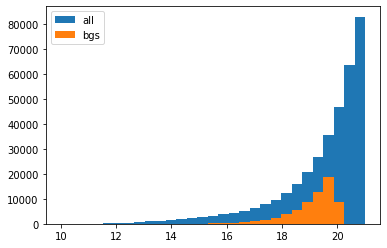

In [27]:
bins = np.linspace(10, 21, 30)
plt.hist(cat['RMAG'], bins=bins, label='all')
plt.hist(cat['RMAG'][bgs], bins=bins, label='bgs')
plt.legend()

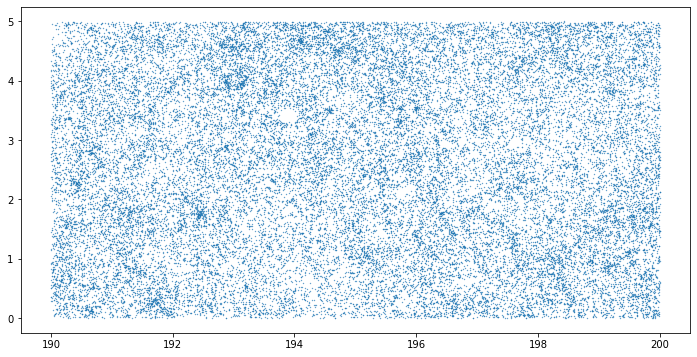

In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(cat['RA'][bgsb], cat['DEC'][bgsb], s=0.1)

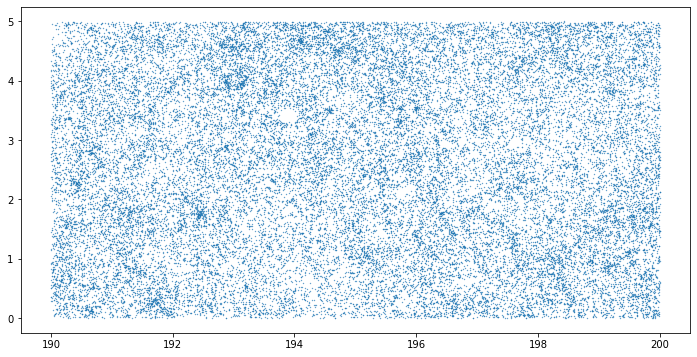

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(cat1['RA'][bgsb1], cat1['DEC'][bgsb1], s=0.1)

## Quickest way to test DESITARGET target selection

In [89]:

def runtest(rff=False, targtype="bright", primary1=False):
    
    targets = Table.read(mastercat)
    flux = cuts.unextinct_fluxes(targets)
    gflux = flux['GFLUX']
    rflux = flux['RFLUX']
    zflux = flux['ZFLUX']
    w1flux = flux['W1FLUX']
    w2flux = flux['W2FLUX']
    zfiberflux = flux['ZFIBERFLUX']
    rfiberflux = flux['RFIBERFLUX']

    gfluxivar = targets['FLUX_IVAR_G']
    rfluxivar = targets['FLUX_IVAR_R']
    zfluxivar = targets['FLUX_IVAR_Z']

    gsnr = targets['FLUX_G'] * np.sqrt(targets['FLUX_IVAR_G'])
    rsnr = targets['FLUX_R'] * np.sqrt(targets['FLUX_IVAR_R'])
    zsnr = targets['FLUX_Z'] * np.sqrt(targets['FLUX_IVAR_Z'])
    w1snr = targets['FLUX_W1'] * np.sqrt(targets['FLUX_IVAR_W1'])
    w2snr = targets['FLUX_W2'] * np.sqrt(targets['FLUX_IVAR_W2'])

    dchisq = targets['DCHISQ']
    deltaChi2 = dchisq[..., 0] - dchisq[..., 1]

    gnobs, rnobs, znobs = targets['NOBS_G'], targets['NOBS_R'], targets['NOBS_Z']
    gallmask = targets['ALLMASK_G']
    rallmask = targets['ALLMASK_R']
    zallmask = targets['ALLMASK_Z']
    gfracflux = targets['FRACFLUX_G']
    rfracflux = targets['FRACFLUX_R']
    zfracflux = targets['FRACFLUX_Z']
    gfracmasked = targets['FRACMASKED_G']
    rfracmasked = targets['FRACMASKED_R']
    zfracmasked = targets['FRACMASKED_Z']
    gfracin = targets['FRACIN_G']
    rfracin = targets['FRACIN_R']
    zfracin = targets['FRACIN_Z']
    maskbits = targets['MASKBITS']
    refcat = targets['REF_CAT']

    gaiagmag = targets['GAIA_PHOT_G_MEAN_MAG']
    Grr = gaiagmag - 22.5 + 2.5*np.log10(targets['FLUX_R'])

    if 'BRICK_PRIMARY' in targets.colnames:
        primary = targets['BRICK_PRIMARY']
    else:
        primary = np.ones_like(gflux, dtype='?')
    
    if rff: ff = rfiberflux
    else: ff = None
    
    if primary1: prim = primary
    else: prim = None
    
    bgs = cuts.isBGS(
        rfiberflux=ff, gflux=gflux, rflux=rflux,
        zflux=zflux, w1flux=w1flux, w2flux=w2flux,
        gnobs=gnobs, rnobs=rnobs, znobs=znobs,
        gfracmasked=gfracmasked, rfracmasked=rfracmasked,
        zfracmasked=zfracmasked, gfracflux=gfracflux,
        rfracflux=rfracflux, zfracflux=zfracflux,
        gfracin=gfracin, rfracin=rfracin, zfracin=zfracin,
        gfluxivar=gfluxivar, rfluxivar=rfluxivar,
        zfluxivar=zfluxivar, maskbits=maskbits,
        Grr=Grr, refcat=refcat, w1snr=w1snr, gaiagmag=gaiagmag,
        primary=prim, targtype=targtype)
                    
    return bgs

In [91]:
for targtype in ['bright', 'faint']:
    bgs_test = runtest(rff=True, targtype=targtype, primary1=False)
    print(targtype, np.sum(bgs_test)/47.)

bright 817.3617021276596
faint 568.2978723404256
